In [1]:
import numpy as np
import torch
print(torch.__version__)

from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

2.0.1+cu118


In [2]:
from utils import eval_model, train, smooth, save_model, load_model, model_params, eval_plots, set_random_seed, eval_model_conf
from dataset_utils import extract_frames

In [3]:
set_random_seed(420)

In [4]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

import os
import shutil

In [5]:
# choose device to be used depending on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### download dataset and unzip

use preloaded from google drive

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
%%shell
mkdir KTH
mkdir KTH/data
mkdir KTH/data/videos

unzip /content/gdrive/MyDrive/KTH/videos/boxing.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/handclapping.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/handwaving.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/jogging.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/running.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/walking.zip -d KTH/data/videos

wget -O sequences_list.txt http://www.csc.kth.se/cvap/actions/00sequences.txt


Archive:  /content/gdrive/MyDrive/KTH/videos/boxing.zip
  inflating: KTH/data/videos/person01_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/

### directly download and unzip

In [ ]:
"""
%%shell
mkdir KTH
mkdir KTH/data
mkdir KTH/data/videos

wget -O KTH/data/videos/boxing.zip http://www.csc.kth.se/cvap/actions/boxing.zip
wget -O KTH/data/videos/handclapping.zip http://www.csc.kth.se/cvap/actions/handclapping.zip
wget -O KTH/data/videos/handwaving.zip http://www.csc.kth.se/cvap/actions/handwaving.zip
wget -O KTH/data/videos/jogging.zip http://www.csc.kth.se/cvap/actions/jogging.zip
wget -O KTH/data/videos/running.zip http://www.csc.kth.se/cvap/actions/running.zip
wget -O KTH/data/videos/walking.zip http://www.csc.kth.se/cvap/actions/walking.zip

unzip KTH/data/videos/boxing.zip -d KTH/data/videos
unzip KTH/data/videos/handclapping.zip -d KTH/data/videos
unzip KTH/data/videos/handwaving.zip -d KTH/data/videos
unzip KTH/data/videos/jogging.zip -d KTH/data/videos
unzip KTH/data/videos/running.zip -d KTH/data/videos
unzip KTH/data/videos/walking.zip -d KTH/data/videos

rm KTH/data/videos/*.zip
"""

'\n%%shell\nmkdir KTH\nmkdir KTH/data\nmkdir KTH/data/videos\n\nwget -O KTH/data/videos/boxing.zip http://www.csc.kth.se/cvap/actions/boxing.zip\nwget -O KTH/data/videos/handclapping.zip http://www.csc.kth.se/cvap/actions/handclapping.zip\nwget -O KTH/data/videos/handwaving.zip http://www.csc.kth.se/cvap/actions/handwaving.zip\nwget -O KTH/data/videos/jogging.zip http://www.csc.kth.se/cvap/actions/jogging.zip\nwget -O KTH/data/videos/running.zip http://www.csc.kth.se/cvap/actions/running.zip\nwget -O KTH/data/videos/walking.zip http://www.csc.kth.se/cvap/actions/walking.zip\n\nunzip KTH/data/videos/boxing.zip -d KTH/data/videos\nunzip KTH/data/videos/handclapping.zip -d KTH/data/videos\nunzip KTH/data/videos/handwaving.zip -d KTH/data/videos\nunzip KTH/data/videos/jogging.zip -d KTH/data/videos\nunzip KTH/data/videos/running.zip -d KTH/data/videos\nunzip KTH/data/videos/walking.zip -d KTH/data/videos\n\nrm KTH/data/videos/*.zip\n'

In [8]:
extract_frames('KTH')

Completed till video :  50
Completed till video :  100
Completed till video :  150
Completed till video :  200
Completed till video :  250
Completed till video :  300
Completed till video :  350
Completed till video :  400
Completed till video :  450
Completed till video :  500
Completed till video :  550
[MESSAGE]	Frames extracted from all videos
[ERROR]:  KTH/data/VALIDATION/person01_boxing_d4_frame_246_370
Completed till video :  50
Completed till video :  100
Completed till video :  150
Completed till video :  200
Completed till video :  250
-----------------------------------------------------------
[ERROR MESSAGE]: 
limits :  ['*missing*']
seq_path :  KTH/data/TRAIN/person13_handclapping_d2_frame_401_523
-----------------------------------------------------------
Completed till video :  300
Completed till video :  350
Completed till video :  400
Completed till video :  450
Completed till video :  500
Completed till video :  550
Completed till video :  600
[ALERT]		Total error cou

### dataset class

In [9]:
import os
import random
from PIL import Image

class KTH_dataset(torch.utils.data.Dataset):

  def __init__(self, DATA_PATH,  transforms = None, mode = 'TRAIN', instance_len = 20):
    self.instances = []
    self.inst_class = []
    self.path = DATA_PATH
    self.mode = mode
    self.transforms = transforms
    self.instance_len = instance_len

    self.mapping = {'boxing':0, 'handclapping':1, 'handwaving':2, 'jogging':3, 'running':4, 'walking':5}

    all_vids = os.listdir(self.path + '/' + self.mode)

    # find all directories for wanted dataset part, and load all file names in these directories
    for vid in all_vids:
      frames = os.listdir(self.path + '/' + self.mode + '/' + vid)
      frames.sort() # sort to make sure that frames in correct order
      current_instance = []

      # split in parts of frames
      for i in range(int(len(frames)/self.instance_len)):
        current_instance = frames[i*self.instance_len: i*self.instance_len + self.instance_len]

        current_instance = [(self.path + '/' + self.mode + '/' + vid + '/' + item) for item in current_instance]

        self.instances.append(current_instance)

        self.inst_class.append(int(self.mapping[vid.split('_')[1]]))


  def __getitem__(self, x):
    instance_img = self.instances[x]
    label = torch.tensor(self.inst_class[x])

    tens_list = []

    # load image and transform to tensor to be able to apply other transforms directly
    for inst in instance_img:
      image = Image.open(inst).convert("RGB")
      inst_tensor = transforms.ToTensor()(image)
      tens_list.append(inst_tensor)
      
    inst_tensor = torch.stack(tens_list, dim=0)

    if self.transforms != None: # apply other transforms. is directly applied at once on all images/channels
      inst_tensor = self.transforms(inst_tensor)

    return inst_tensor, label

  def __len__(self):
    return len(self.instances)


In [10]:
"""
# only for testing of dataset class

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
               ])

dset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'TRAIN', instance_len = 30)
"""

In [49]:
train_transforms = transforms.Compose([
               transforms.RandomHorizontalFlip(p=0.5),
               transforms.RandomRotation(degrees=5),
               transforms.Resize((64, 64), antialias=True),
               ])

test_transforms = transforms.Compose([
               transforms.Resize((64, 64), antialias=True),
               ])

n_frames = 30


train_dataset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'TRAIN', instance_len = n_frames)
val_dataset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'VALIDATION', instance_len = n_frames)

# use validation set to train too, as we do not use it here in another way
train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])  

test_dataset = KTH_dataset('/content/KTH/data',  transforms = test_transforms, mode = 'TEST', instance_len = n_frames)


print(f"Train samples: {len(train_dataset)}")
#print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 4219
Test samples: 2248


# model with gru from pytorch

In [43]:
class GRUModel(nn.Module):
    def __init__(self, input_dims, emb_dims, output_features, num_layers=1, kernel_size = 3, hidden_dim = 3328):
        super().__init__()

        self.input_dims = input_dims
        self.emb_dims = emb_dims

        self.output_features = output_features
        self.num_layers = num_layers
        self.kernel_size = kernel_size
      

        # embedding cnn
        self.encoder = nn.Sequential(
          nn.Conv3d(in_channels=self.input_dims[1], out_channels=16, kernel_size = (1,self.kernel_size,self.kernel_size), stride=(1,1,1), padding = (0,int(self.kernel_size/2),int(self.kernel_size/2))),
          nn.ReLU(),
          nn.MaxPool3d((1,2,2), stride=(1,2,2)),
          nn.Dropout(p=0.5),
          nn.Conv3d(in_channels=16, out_channels=self.emb_dims[0], kernel_size = (1,self.kernel_size,self.kernel_size), stride=(1,1,1), padding = (0,int(self.kernel_size/2),int(self.kernel_size/2))),
          nn.ReLU(),
          nn.MaxPool3d((1,2,2), stride=(1,2,2)),
          nn.Dropout(p=0.5),
          )
      

        emb_inp = emb_dims[0]*emb_dims[1]*emb_dims[2]

        # GRU layer
        h = []
        for i in range(num_layers):
          h.append(nn.Parameter(
                torch.randn(1,hidden_dim).requires_grad_())
            )
        self.h = nn.ParameterList(h)

        grus = []
        for i in range(num_layers):
            in_size = emb_inp if i == 0 else hidden_dim
            grus.append( nn.GRUCell(input_size=in_size, hidden_size=hidden_dim) )
        self.gru = nn.ModuleList(grus)

        
        
        # classifier
        self.classifier = nn.Sequential(
          nn.Dropout(p=0.5),
          nn.Linear(in_features=hidden_dim, out_features=64),
          nn.ReLU(),
          nn.Linear(in_features=64, out_features=self.output_features),
          )
        
        return
    
    def forward(self, x):
        b_size, n_frames, n_channels, n_rows, n_cols = x.shape

        x_t = x.transpose(1,2) # transpose to be able to use conv3d and maxpool 3d correctly

        out = self.encoder(x_t)

        out = out.transpose(1,2)  # transpose for lstm layers
        out = out.reshape(b_size, n_frames, -1)

        for j in range(self.num_layers):
          h_stacked = self.h[j].repeat(b_size,1)

          h_l = [h_stacked]
          for i in range(out.shape[1]):
            input = out[:,i,:]
            ht = self.gru[j](input, h_l[-1])
            h_l.append(ht)
            

          out = torch.stack(h_l[1:len(h_l)])  # dont take init value for h in output
          out = out.reshape((b_size, n_frames,-1))


        out = self.classifier(out[:, -1, :])  # output of lstm layer
        
        return out
    

In [44]:
torch_gru = GRUModel(input_dims = (n_frames, 3,64,64), emb_dims = (16,16,16), output_features = 6, num_layers=1, kernel_size = 5, hidden_dim = 3328)
torch_gru.to(device)

GRUModel(
  (encoder): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (5): ReLU()
    (6): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
  )
  (h): ParameterList(  (0): Parameter containing: [torch.float32 of size 1x3328 (GPU 0)])
  (gru): ModuleList(
    (0): GRUCell(4096, 3328)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3328, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [45]:
print(f"The model has {model_params(torch_gru)} parameters.")

The model has 74365590 parameters.


> The number of paramters is much higher than the number of parameters of our convLSTM (74365590 vs. 323606), but lower than the number of parameters in the torch LSTM model (99082646).

In [46]:
BATCH_SIZE = 32
SHUFFLE_TRAIN = True
NUM_EPOCHS = 14
LR = 3e-4
EVAL_FREQ = 1
SAVE_FREQ = 2


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [47]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer0 = torch.optim.Adam(torch_gru.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every X epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer0, step_size=14, gamma=0.2)

In [48]:
import time
start_time = time.time()
stats0, model0 = train(torch_gru, NUM_EPOCHS, train_loader, None, val_loader, optimizer0, criterion, EVAL_FREQ, SAVE_FREQ, '/content', device, scheduler, twriter = None, loadpath = None, stats = None)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch -1: valid_loss 1.78672 valid_acc 20.73 | lr 0.0003


100%|██████████| 132/132 [03:06<00:00,  1.41s/it]


Epoch 1: train_loss 1.75145 | valid_loss 1.74680 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:05<00:00,  1.40s/it]


Epoch 2: train_loss 1.73709 | valid_loss 1.73254 valid_acc 23.40| lr 0.0003


100%|██████████| 132/132 [02:58<00:00,  1.35s/it]


Epoch 3: train_loss 1.73288 | valid_loss 1.73991 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [02:57<00:00,  1.35s/it]


Epoch 4: train_loss 1.72926 | valid_loss 1.73230 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:03<00:00,  1.39s/it]


Epoch 5: train_loss 1.73096 | valid_loss 1.73309 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [02:57<00:00,  1.35s/it]


Epoch 6: train_loss 1.72828 | valid_loss 1.73358 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:00<00:00,  1.37s/it]


Epoch 7: train_loss 1.73113 | valid_loss 1.73160 valid_acc 23.40| lr 0.0003


100%|██████████| 132/132 [03:03<00:00,  1.39s/it]


Epoch 8: train_loss 1.72943 | valid_loss 1.72914 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:00<00:00,  1.37s/it]


Epoch 9: train_loss 1.72940 | valid_loss 1.73061 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:19<00:00,  1.51s/it]


Epoch 10: train_loss 1.72867 | valid_loss 1.73098 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:06<00:00,  1.41s/it]


Epoch 11: train_loss 1.72969 | valid_loss 1.73527 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:04<00:00,  1.40s/it]


Epoch 12: train_loss 1.72846 | valid_loss 1.73169 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:01<00:00,  1.37s/it]


Epoch 13: train_loss 1.72867 | valid_loss 1.73043 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:06<00:00,  1.42s/it]


Epoch 14: train_loss 1.72927 | valid_loss 1.73445 valid_acc 23.35| lr 0.0003
--- 3451.339483976364 seconds ---


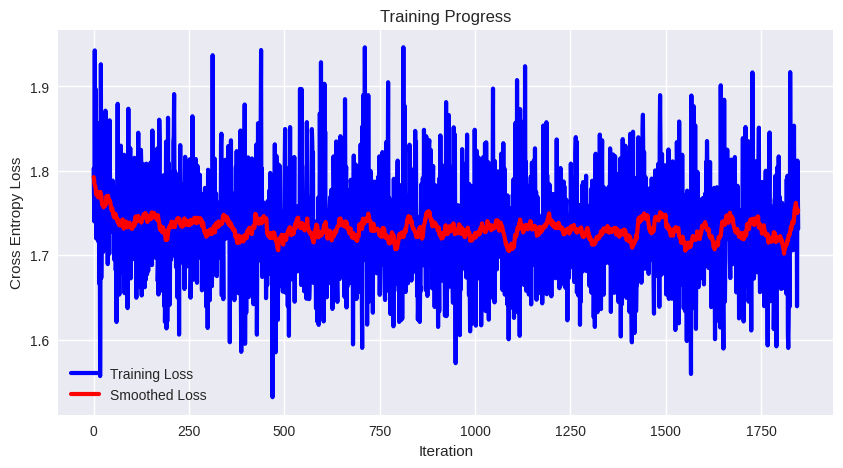

In [50]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

smooth_loss = smooth(stats0["per_batch_loss"], 31)
ax.plot(stats0["per_batch_loss"], c="blue", label="Training Loss", linewidth=3)#, alpha=0.5)
ax.plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax.legend(loc="best")
ax.set_xlabel("Iteration")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Training Progress")

plt.show()

Classification accuracy: 23.35%


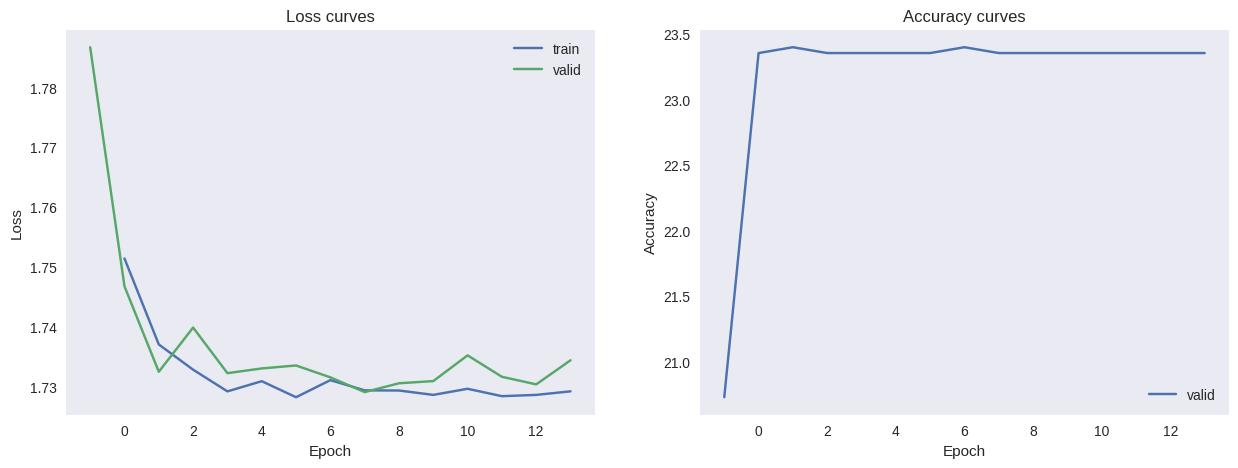

In [51]:
eval_plots(model0, val_loader, criterion, device, stats0)

> GRU performs much better than LSTM with the given data. Maybe GRUs lesser complexity compared to LSTM decreases the risk of overfitting. LSTM probably has a much higher capability to pass on information through time (with its two states), which makes it much more prone to overfitting.
> Maybe GRU performs better on data with low variability (many instances in the dataset (30 frames) are from the same video)
> The performance with GRU is about the same as the performance with our convLSTM, however with a much higher number of parameters (about 20 times more parameters).

0:boxing, 1:handclapping, 2:handwaving, 3:jogging, 4:running, 5:walking
Test accuracy: 23.35%
F1 Score: 0.23%


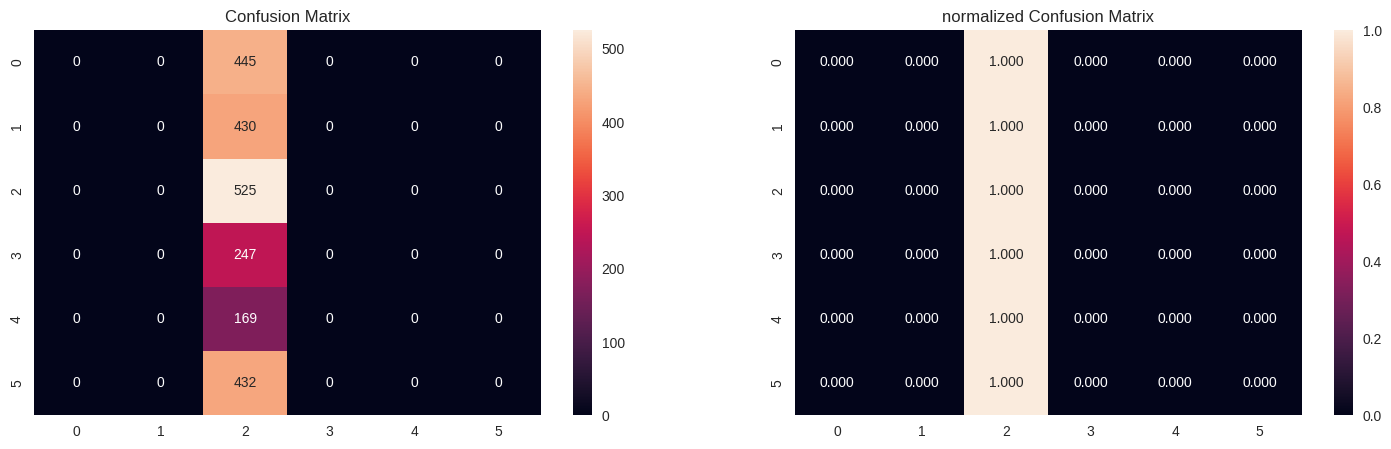

In [53]:
_, _, correct_labels, predicted_labels = eval_model_conf(model0, val_loader, criterion, device)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# calculate absolute confusion matrix
confusion_matr = confusion_matrix(correct_labels, predicted_labels)#, labels=[0,1,2,3,4,5,6,7,8,9])
df_confusion = pd.DataFrame(confusion_matr, range(confusion_matr.shape[0]), range(confusion_matr.shape[0]))
# calculate confusion matric normalized in rows
confusion_matr_norm = confusion_matrix(correct_labels, predicted_labels, normalize = 'true') #, labels=[0,1,2,3,4,5,6,7,8,9]
df_confusion_norm = pd.DataFrame(confusion_matr_norm, range(confusion_matr_norm.shape[0]), range(confusion_matr_norm.shape[0]))

print('0:boxing, 1:handclapping, 2:handwaving, 3:jogging, 4:running, 5:walking')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("True Label")
ax[0].set_title("Confusion Matrix")
sn.heatmap(df_confusion, annot=True, annot_kws={"size": 10}, fmt="d", ax=ax[0]) 


ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("True Label")
ax[1].set_title("normalized Confusion Matrix")
sn.heatmap(df_confusion_norm, annot=True, annot_kws={"size": 10}, fmt=".3f", ax=ax[1]) 

acc = 0
for i in range(confusion_matr.shape[0]):
  acc = acc + confusion_matr[i,i]
acc = acc/confusion_matr.sum()*100
print(f"Test accuracy: {round(acc,2)}%")

print(f"F1 Score: {round(f1_score(correct_labels, predicted_labels, average = 'micro'),2)}%")